# Example 4 of Phoeniks
> **P**ULS **h**ands-on **o**ptimized **e**xtraction *of* $\boldsymbol{n} - \boldsymbol{i}\cdot \boldsymbol{k}$'s


Extract refractive index and absorption as well as thickness of the sample from a reference trace and sample trace, which are real world measurements (no longer artificial simulations).

In [1]:
# General Python libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
#%matplotlib notebook
%matplotlib widget
!cd "C:\Users\Hasan\Desktop\phoeniks-main\examples\01_Basic_Extraction"
home_dir = os.getcwd()
os.chdir(r"../..")
# Own library
import phoeniks as pk
os.chdir(home_dir)

In [2]:
help(pk)

Help on package phoeniks:

NAME
    phoeniks

PACKAGE CONTENTS
    artificial_sample
    extraction
    optimization_problem
    plot
    post_processing
    svmaf
    thz_data

DATA
    __all__ = ['extraction', 'optimization_problem', 'plot', 'svmaf', 'thz...

FILE
    c:\users\hasan\desktop\phoeniks-main\phoeniks\__init__.py




# Load data
Loading reference file.

In [3]:
ref_file = "reference_mean.txt"
ref = np.loadtxt(ref_file)
ref, ref.shape

(array([[-7.50078677e+02, -4.11307867e-05],
        [-7.50045344e+02, -7.62292763e-05],
        [-7.50012011e+02, -4.84779818e-05],
        ...,
        [-6.90179191e+02,  2.71826790e-03],
        [-6.90145858e+02,  2.70660625e-03],
        [-6.90112525e+02,  2.70025403e-03]]),
 (1800, 2))

The first column contains the signal in [s], the second column the signal in [V].
We can use the first column to derive the time-axis for the signal and save it seperately:

In [4]:
time = 1e-12 * ref[:, 0]

Load the sample file. For this artificial sample, a thickness of 1 mm was used.

In [5]:
sample_thickness = 450e-6
sam_file = "BNA_4_vert_300_K.txt"
sam = np.loadtxt(sam_file)
sam, sam.shape

(array([[-7.50078677e+02, -4.76957653e-04],
        [-7.50045344e+02, -5.50886627e-05],
        [-7.50012011e+02, -3.32812877e-04],
        ...,
        [-6.90179191e+02,  4.61849985e-03],
        [-6.90145858e+02,  4.87577341e-03],
        [-6.90112525e+02,  3.68465281e-03]]),
 (1800, 2))

# Create data object
Feed this data into the THz data object. As a bare minimum, the following data needs to be supplied:
1. time-axis (same for reference and sample trace)
2. Signal of reference measurement in time-domain
3. Signal of sample measurement in time-domain

In [6]:
data = pk.thz_data.Data(time, ref[:, 1], sam[:, 1])

In [7]:
data.window_traces(time_start=-740e-12, time_end=-695e-12)
data.pad_zeros(new_frequency_resolution=2e9)

# Plot data
To get a better view on the data, we can create a plot of reference and sample file:

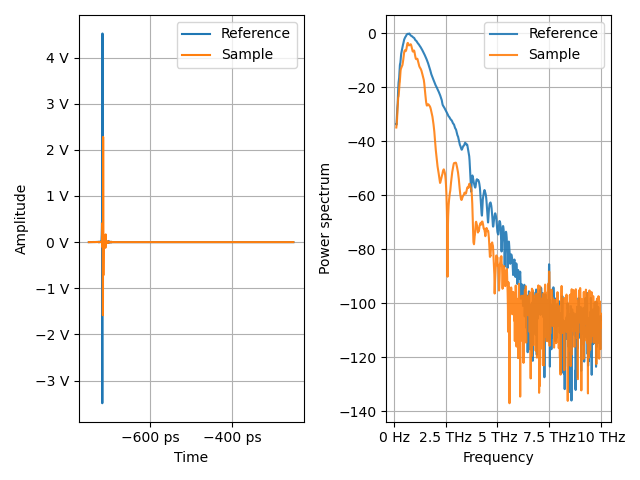

In [8]:
plot = pk.plot.Plot()
plot.plot_data(data)

## Extraction of optimal thickness

In [9]:
extract_obj = pk.extraction.Extraction(data)

In [10]:
extract_obj.unwrap_phase(frequency_start=0.6e12, frequency_stop=1.9e12)

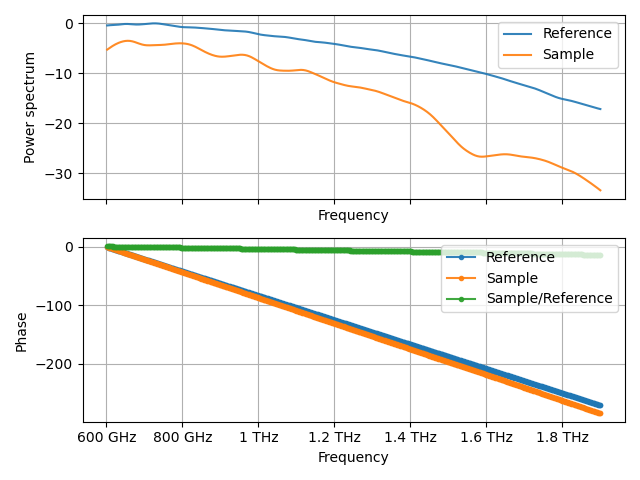

In [11]:
plot.plot_phase(extract_obj)

In [12]:
n, k = extract_obj.get_initial_nk(thickness=sample_thickness)
delta_max = extract_obj.get_max_delta(thickness=sample_thickness)

In [13]:
EngFormatter('m')(sample_thickness)

'450 µm'

In [14]:
thickness_array, tv_dict = extract_obj.get_thickness_array(thickness=sample_thickness,
                                                           thickness_range=100e-6,
                                                           step_size=5e-6)

  0%|          | 0/41 [00:00<?, ?it/s]

Total Variation, deg=1, optimal thickness: 455 µm
Total Variation, deg=2, optimal thickness: 465 µm
Total Variation, Nick's method, optimal thickness: 455 µm
Offset exponential, optimal thickness: 390 µm


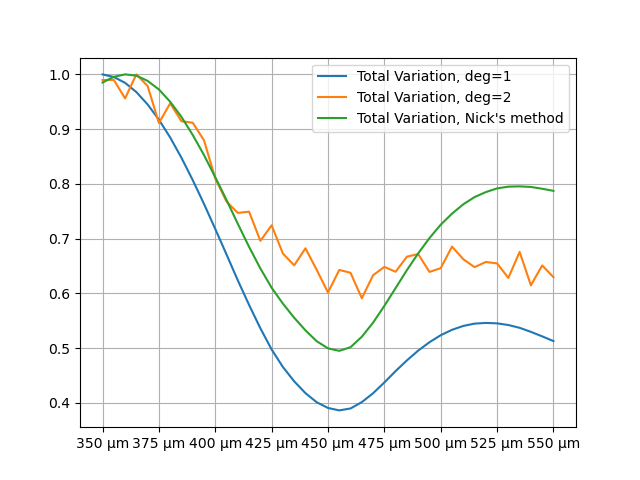

In [16]:
"""
fig, ax = plt.subplots()
ax.plot(thickness_array, tv_dict["tv_1"], label="TotalVariation, deg=1")
ax.plot(thickness_array, tv_dict["tv_2"],label="TotalVariation, deg=2")
ax.plot(thickness_array, tv_dict["tv_n"],label="TotalVariation, Nick's method")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(EngFormatter("m"))
"""
fig, ax = plt.subplots()
ax.plot(thickness_array, tv_dict["Total Variation, deg=1"], label="Total Variation, deg=1")
ax.plot(thickness_array, tv_dict["Total Variation, deg=2"], label="Total Variation, deg=2")
ax.plot(thickness_array, tv_dict["Total Variation, Nick's method"], label="Total Variation, Nick's method")
plt.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(EngFormatter("m"))
plt.show()

# Extraction
Start the extraction of the refractive index and absorption.
It is helpfull, to create an extraction object:

In [17]:
data = pk.thz_data.Data(time, ref[:, 1], sam[:, 1])
data.window_traces(time_start=-740e-12, time_end=-695e-12)
data.pad_zeros(new_frequency_resolution=2e9)
extract_obj = pk.extraction.Extraction(data)

In [18]:
extract_obj.unwrap_phase(frequency_start=0.3e12, frequency_stop=5.7e12)

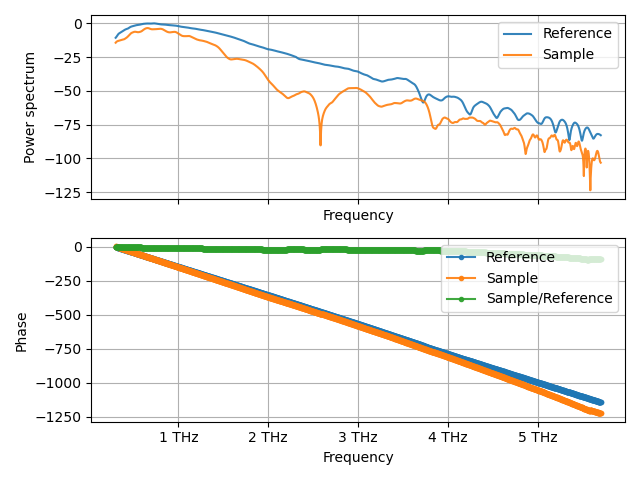

In [19]:
plot.plot_phase(extract_obj)

Getting a first guess of n and k, which is necessary for the optimization algorithm. Looking at the time-domain, we cannot only measure the time delta between the peak of reference and sample trace, but also how many echoes (Fabry-Perot reflections) would fit in the remaining time trace:

In [20]:
n, k = extract_obj.get_initial_nk(thickness=sample_thickness)
delta_max = extract_obj.get_max_delta(thickness=sample_thickness)
print(f"Δt:\t\t{EngFormatter('s', places=1)(extract_obj.get_time_shift())}")
print(f"Max. echoes:\t{delta_max}\n")

Δt:		1.6 ps
Max. echoes:	4



# Run optimization

In [21]:
frequency, n_opt, k_opt, alpha_opt = extract_obj.run_optimization(thickness=sample_thickness)

  0%|          | 0/2700 [00:00<?, ?it/s]

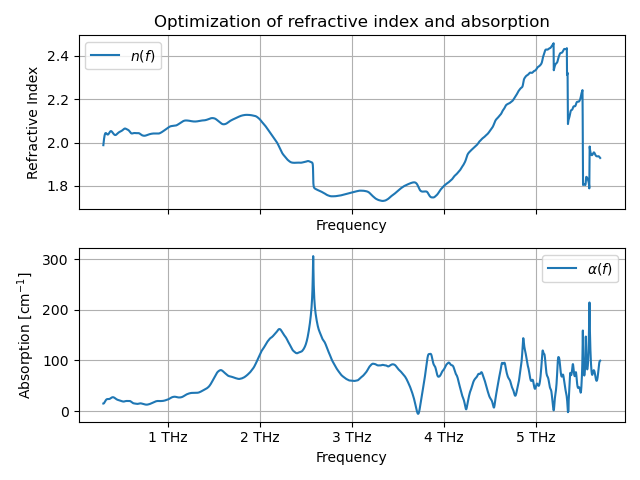

In [22]:
from scipy.constants import c as c_0
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].set_title("Optimization of refractive index and absorption")
ax[0].plot(frequency, n_opt, label=r"$n(f)$")
ax[0].xaxis.set_major_formatter(EngFormatter("Hz"))
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Refractive Index")
ax[0].grid(True)
ax[0].legend()


ax[1].plot(frequency, 0.01 * alpha_opt, label=r"$\alpha(f)$")
ax[1].xaxis.set_major_formatter(EngFormatter("Hz"))
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel(r"Absorption [$\mathrm{cm}^{-1}$]")
ax[1].grid(True)
ax[1].legend()
plt.tight_layout()